In [152]:
import warnings;
warnings.filterwarnings('ignore');

In [153]:
import pandas as pd
from my_utils import loader
import os
import pymc3 as pm
import arviz as az
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
from theano import tensor as T
from my_utils import modeler
import importlib
importlib.reload(modeler)
from sklearn.metrics import accuracy_score

## __Free viewing__

### __General empathy__

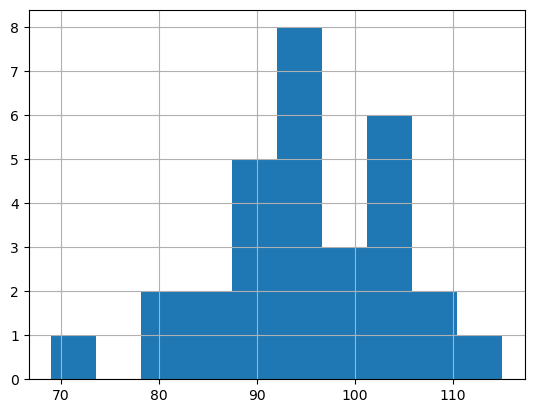

In [150]:
free_viewing_empathy = modeler.get_empathy_levels(experiment= "free")
free_viewing_empathy.hist();

#### __Fixations__

In [154]:
free_fix_features_train, free_fix_labels_train, free_sac_features_train, free_sac_labels_train =  modeler.get_features_and_labels("train", "free")

In [13]:
free_fix_labels_train_class = np.array([1 if level >= 95 else 0 for level in free_fix_labels_train])
free_fix_labels_train_class

array([1, 1, 1, ..., 0, 0, 0])

In [39]:
with pm.Model() as free_fix_empathy:
    X = pm.Data("x", free_fix_features_train)
    y = pm.Data("y", free_fix_labels_train_class)
    
    beta = pm.Normal("beta", mu=0, sigma=1, shape=free_fix_features_train.shape[1])
    logit = T.dot(X, beta.T)
    pm.Bernoulli("empathy", pm.math.sigmoid(logit), observed=y, shape = X.eval().shape[0])
    
    free_fix_empathy_trace = pm.sample(1000, random_seed=0)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 292 seconds.


In [40]:
with open("models/free_fix_logistic_regression.pickle", 'wb') as buff:
    pickle.dump({'model': free_fix_empathy, 'trace': free_fix_empathy_trace}, buff)

In [16]:
az.summary(free_fix_empathy_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.230,0.881,-1.840,1.421,0.013,0.012,4246.0,3040.0,1.0
beta[1],1.660,0.210,1.270,2.061,0.004,0.003,3183.0,2789.0,1.0
beta[2],0.557,0.851,-0.955,2.236,0.015,0.013,3066.0,2692.0,1.0
beta[3],-0.252,0.763,-1.603,1.232,0.012,0.011,4184.0,3203.0,1.0
beta[4],0.616,0.372,-0.125,1.268,0.006,0.004,4039.0,2746.0,1.0
beta[5],-1.158,0.608,-2.343,-0.063,0.011,0.008,3281.0,2899.0,1.0
beta[6],-1.112,0.519,-2.131,-0.178,0.010,0.007,2940.0,3055.0,1.0
beta[7],0.492,0.114,0.279,0.708,0.002,0.001,4287.0,2810.0,1.0
beta[8],-1.601,0.451,-2.458,-0.766,0.008,0.006,2893.0,2402.0,1.0
beta[9],1.508,0.578,0.449,2.616,0.011,0.008,2761.0,2958.0,1.0


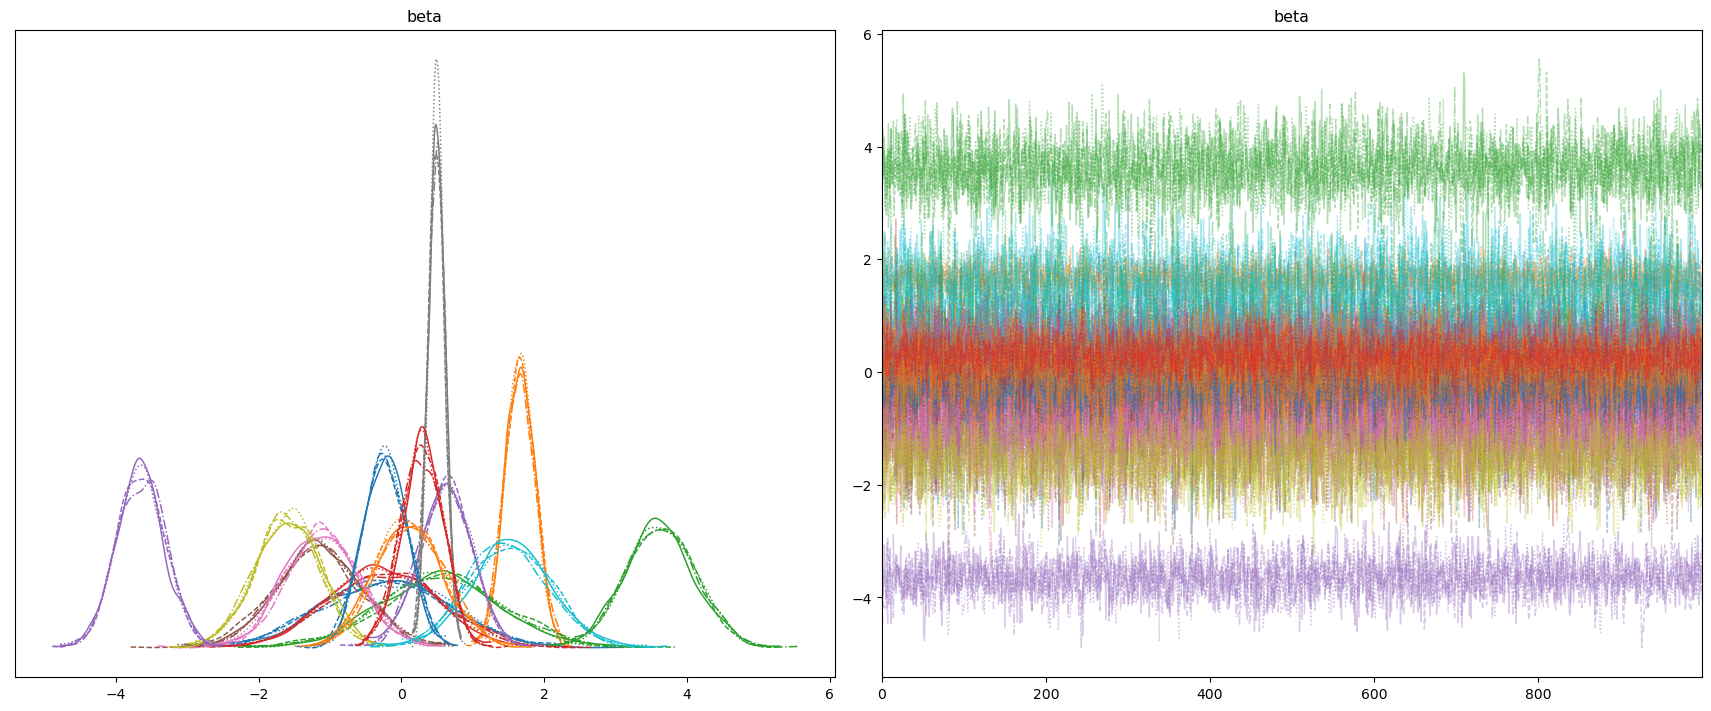

In [17]:
az.plot_trace(free_fix_empathy_trace, figsize=(17,7), divergences=None);

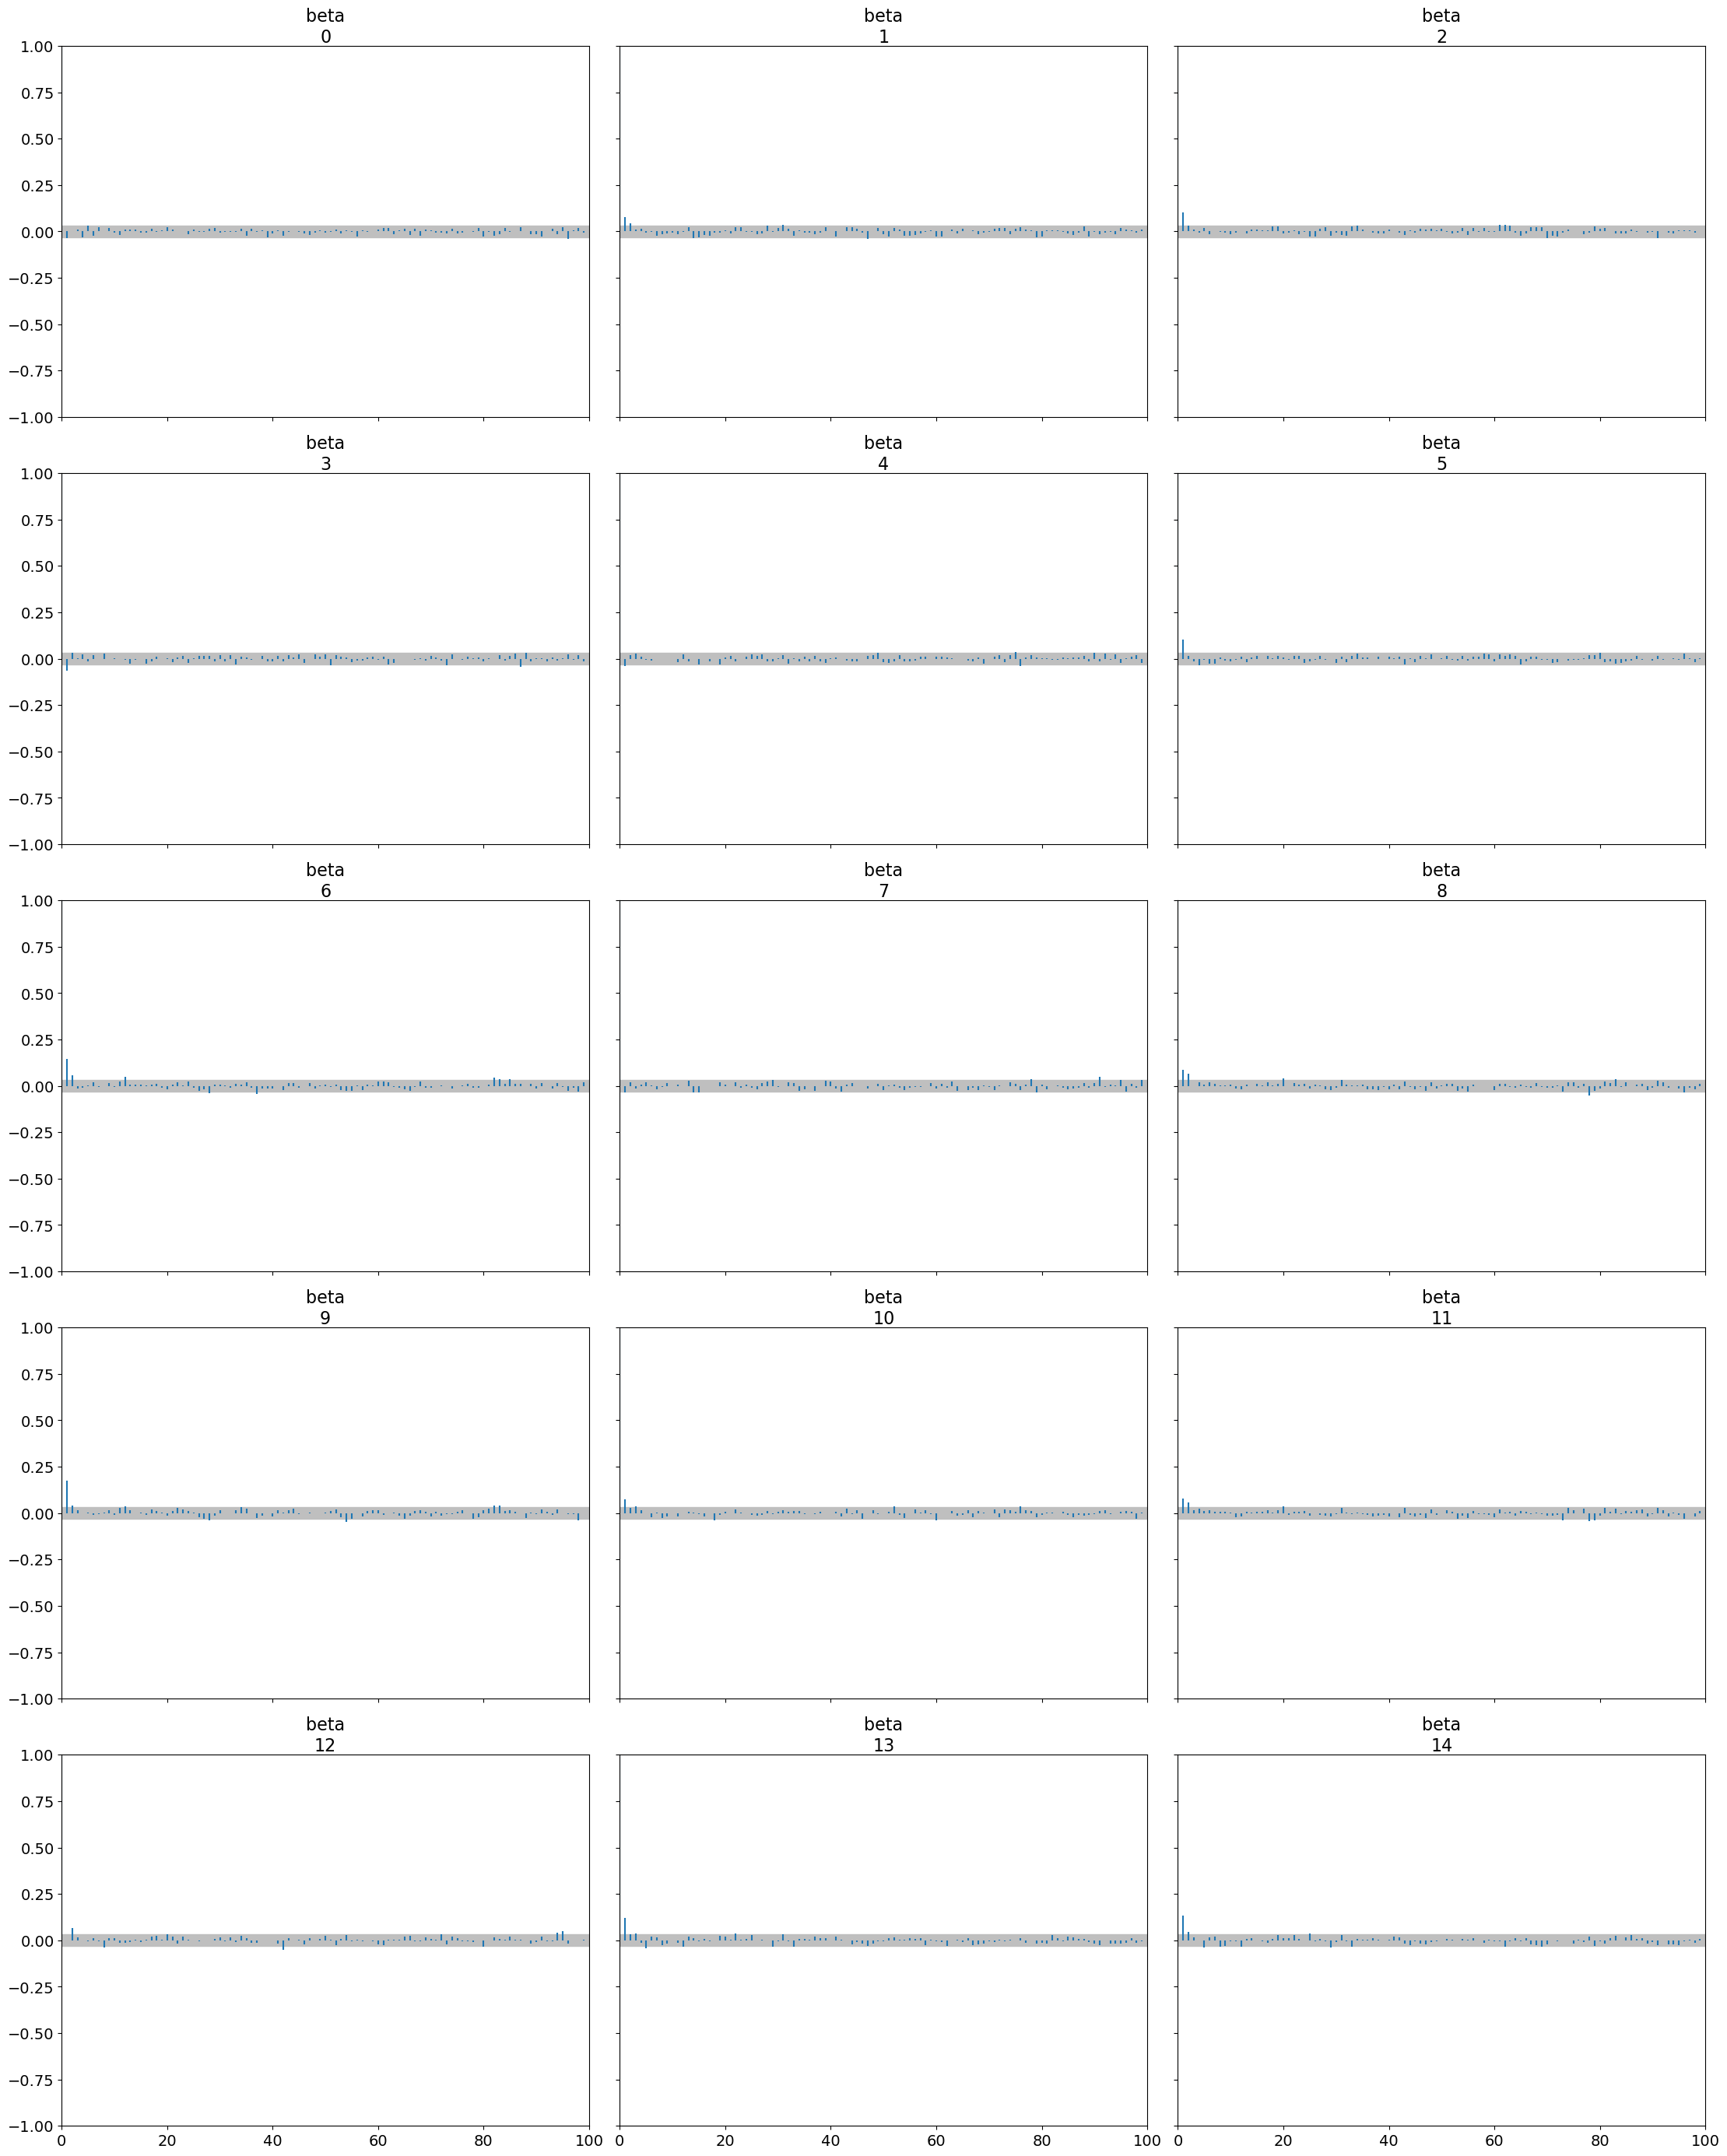

In [18]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

In [19]:
with free_fix_empathy:
    fix_free_ppc = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [20]:
fix_free_ppc_data = az.from_pymc3(model=free_fix_empathy, posterior_predictive=fix_free_ppc) 
fix_free_sampled_labels = fix_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))
y_pred = np.where(fix_free_sampled_labels >= 0.5, 1, 0)
accuracy_score(free_fix_labels_train_class, y_pred)

0.6637187076528065

In [34]:
free_fix_features_test, free_fix_labels_test, free_sac_features_test, free_sac_labels_test =  modeler.get_features(AGGREGATED_PATH, "test", "free")

In [50]:
free_fix_labels_test_class = np.array([1 if level >= 95 else 0 for level in free_fix_labels_test])
free_fix_labels_test_class

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
with free_fix_empathy:
    pm.set_data({"x": free_fix_features_test})
    fix_free_pcc_pred = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [53]:
fix_free_ppc_pred_data = az.from_pymc3(model=free_fix_empathy, posterior_predictive=fix_free_pcc_pred) 
fix_free_pred_prob = fix_free_ppc_pred_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))
fix_free_pred = np.where(fix_free_pred_prob >= 0.5, 1, 0)
accuracy_score(free_fix_labels_test_class, fix_free_pred)

0.6490292297845104

#### __Saccades__

In [54]:
free_sac_labels_train_class = np.array([1 if level >= 95 else 0 for level in free_sac_labels_train])
free_sac_labels_train_class

array([1, 1, 1, ..., 0, 0, 0])

In [56]:
with pm.Model() as free_sac_empathy:
    X = pm.Data("x", free_sac_features_train)
    y = pm.Data("y", free_sac_labels_train_class)
    
    beta = pm.Normal("beta", mu=0, sigma=1, shape=free_sac_features_train.shape[1])
    logit = T.dot(X, beta.T)
    pm.Bernoulli("empathy", pm.math.sigmoid(logit), observed=y, shape=X.eval().shape[0])
    
    free_sac_empathy_trace = pm.sample(1000, random_seed=0)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 138 seconds.


In [57]:
with open("models/free_sac_logistic_regression.pickle", 'wb') as buff:
    pickle.dump({'model': free_sac_empathy, 'trace': free_sac_empathy_trace}, buff)

In [58]:
az.summary(free_sac_empathy_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.776,0.442,-0.054,1.599,0.007,0.005,3935.0,2856.0,1.0
beta[1],-0.078,0.145,-0.355,0.185,0.002,0.002,3657.0,2748.0,1.0
beta[2],-0.125,0.686,-1.435,1.142,0.011,0.011,3725.0,2902.0,1.0
beta[3],-0.256,0.671,-1.539,0.986,0.010,0.010,4295.0,2898.0,1.0
beta[4],-0.225,0.641,-1.411,0.989,0.009,0.010,4868.0,3014.0,1.0
beta[5],0.181,0.545,-0.858,1.193,0.009,0.008,3792.0,3093.0,1.0
beta[6],-0.033,0.369,-0.720,0.655,0.006,0.006,3467.0,2980.0,1.0
beta[7],0.134,0.082,-0.019,0.285,0.001,0.001,4703.0,3063.0,1.0
beta[8],0.270,0.354,-0.408,0.935,0.006,0.005,3482.0,2605.0,1.0
beta[9],0.029,0.490,-0.844,0.964,0.009,0.008,3160.0,2620.0,1.0


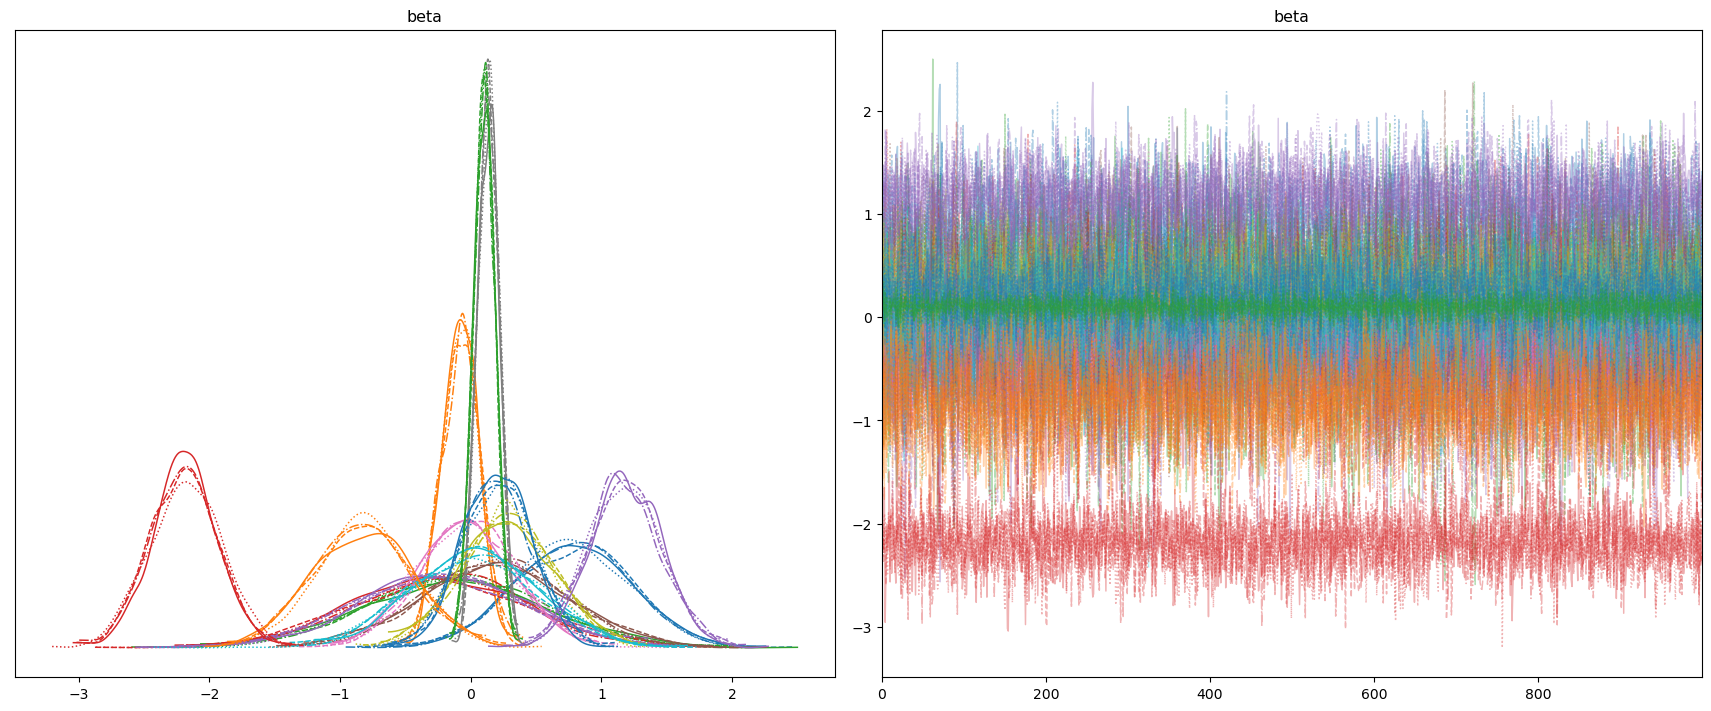

In [59]:
az.plot_trace(free_sac_empathy_trace, figsize=(17,7), divergences=None);

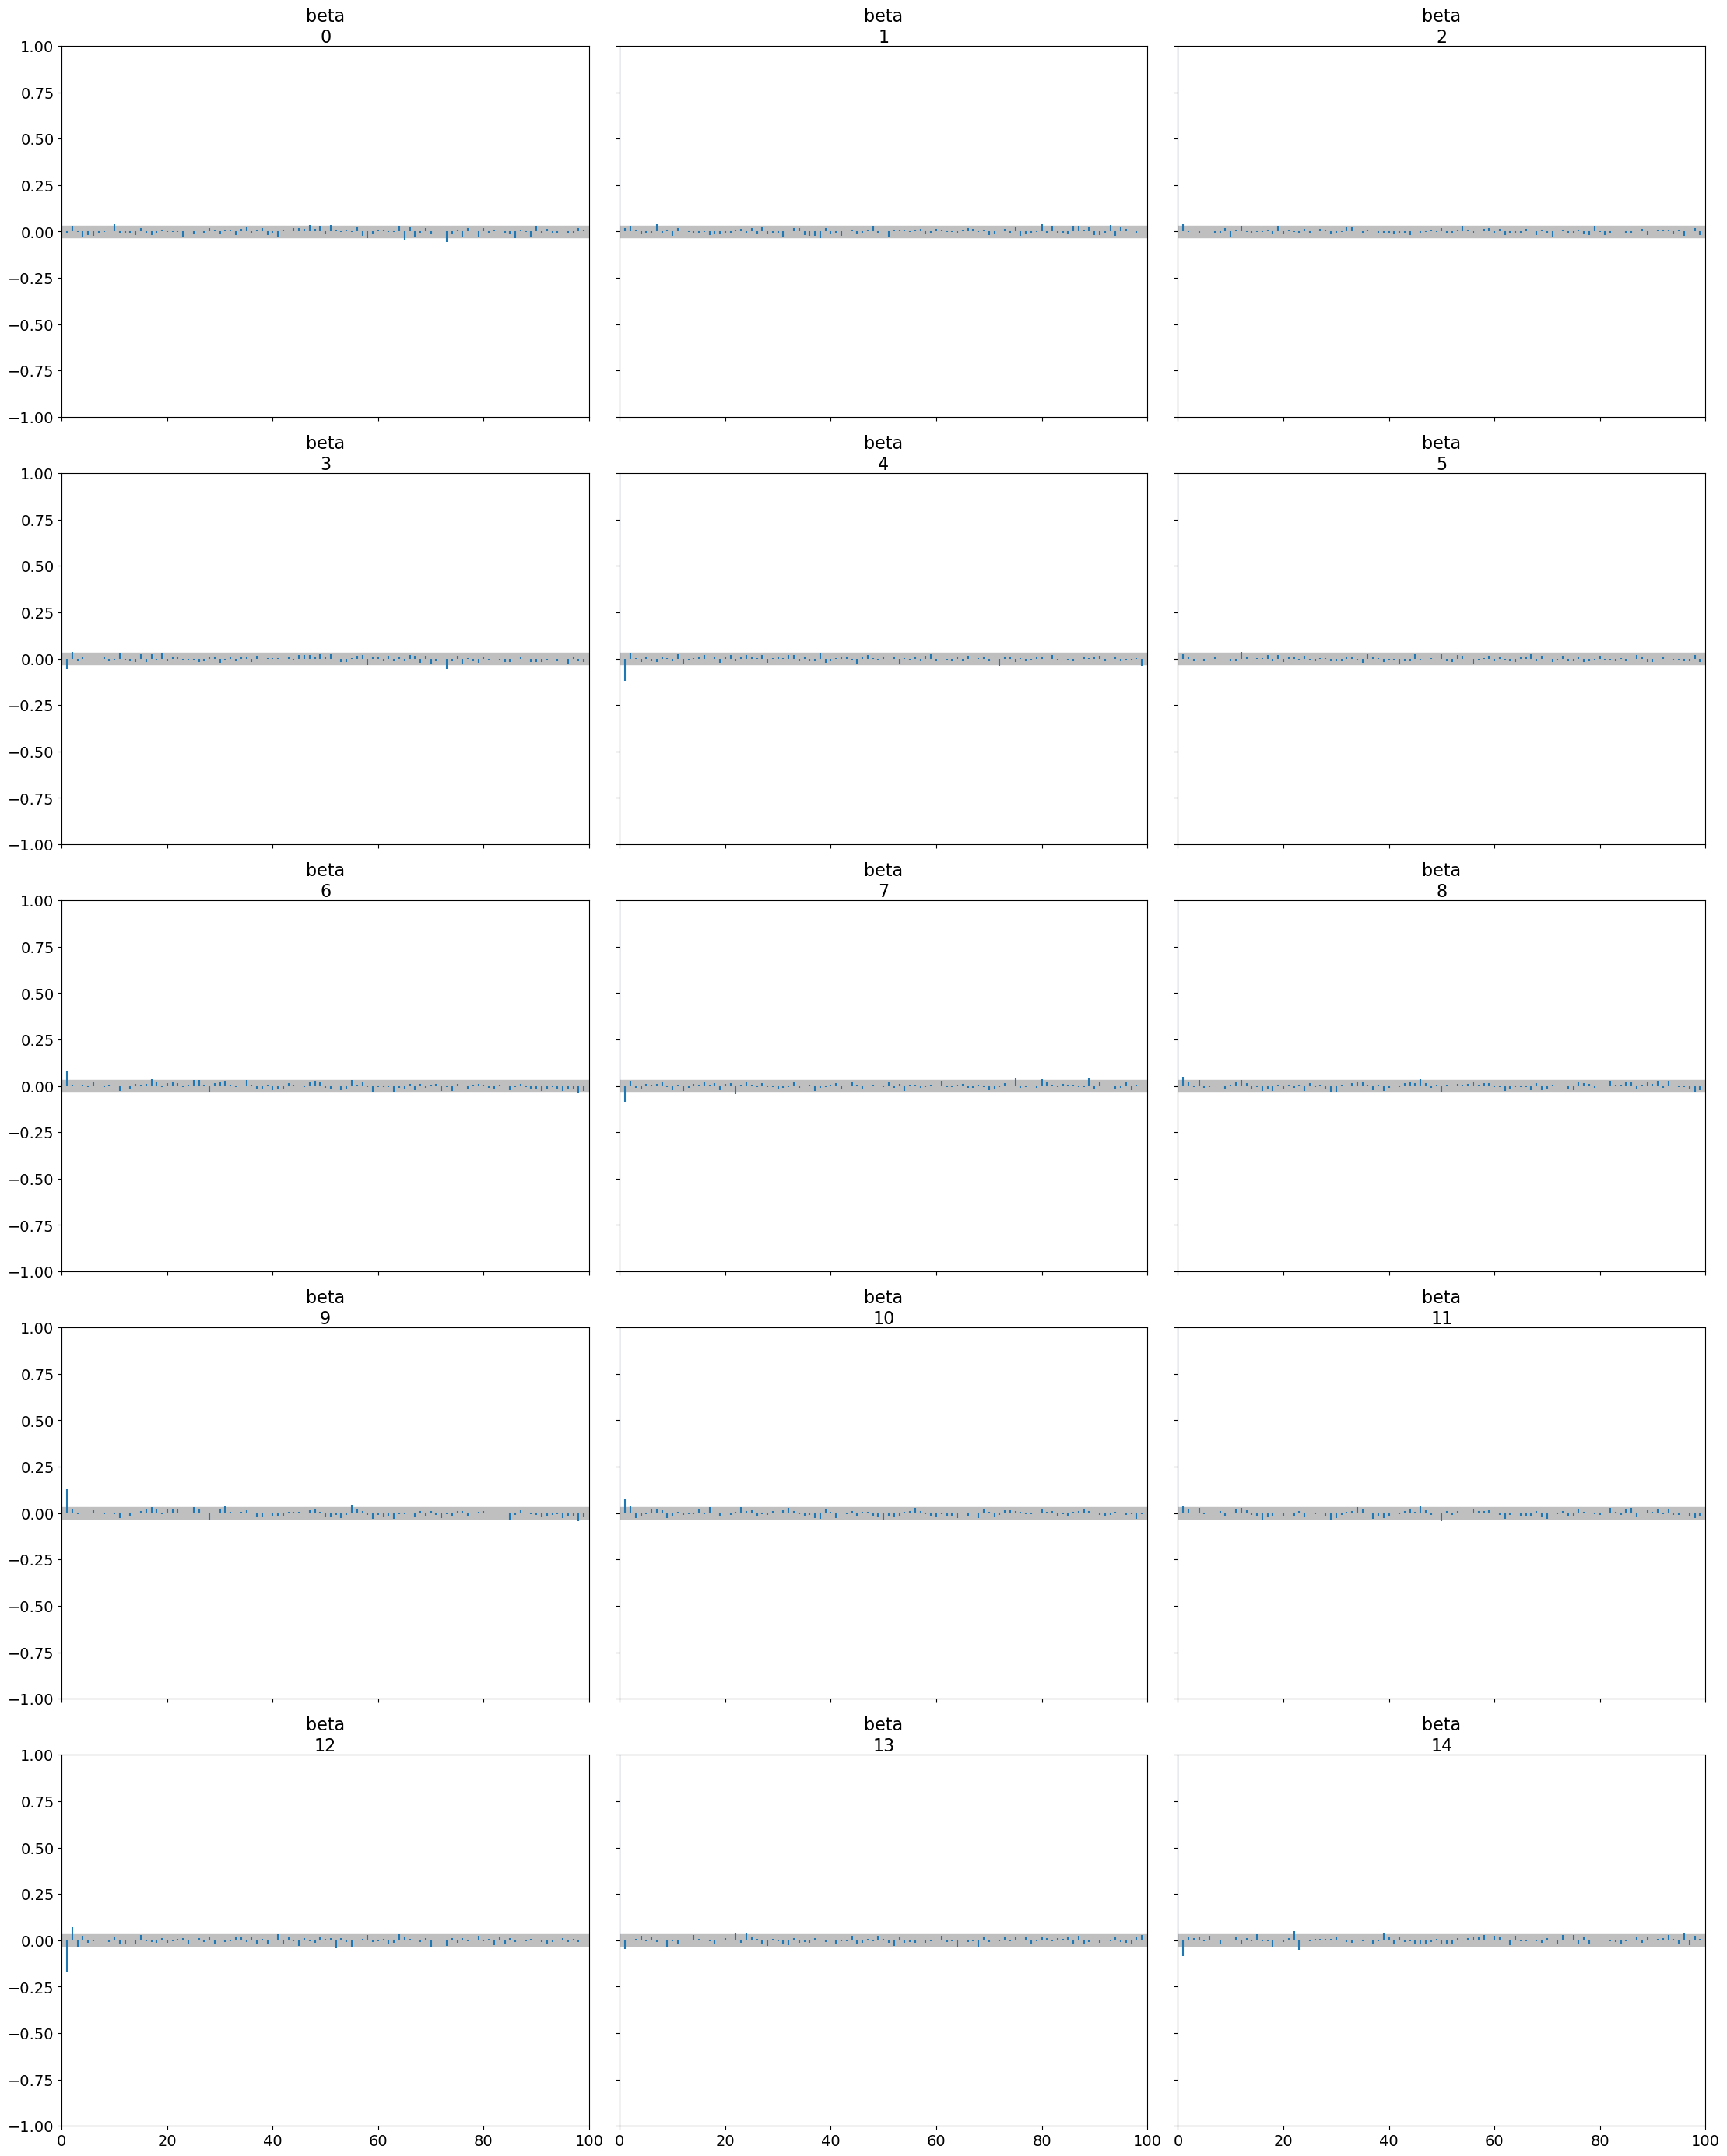

In [60]:
az.plot_autocorr(free_sac_empathy_trace, combined=True);

In [61]:
with free_sac_empathy:
    sac_free_ppc = pm.sample_posterior_predictive(free_sac_empathy_trace)

In [62]:
sac_free_ppc_data = az.from_pymc3(model=free_sac_empathy, posterior_predictive=sac_free_ppc) 
sac_free_sampled_labels = sac_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))
y_pred = np.where(sac_free_sampled_labels >= 0.5, 1, 0)
accuracy_score(free_sac_labels_train_class, y_pred)

0.57651317112407

In [73]:
sac_fix_labels_test_class = np.array([1 if level >= 95 else 0 for level in free_sac_labels_test])

In [64]:
with free_sac_empathy:
    pm.set_data({"x": free_sac_features_test})
    sac_free_pcc_pred = pm.sample_posterior_predictive(free_sac_empathy_trace)

In [74]:
sac_free_ppc_pred_data = az.from_pymc3(model=free_sac_empathy, posterior_predictive=sac_free_pcc_pred) 
sac_free_pred_prob = sac_free_ppc_pred_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))
sac_free_pred = np.where(sac_free_pred_prob >= 0.5, 1, 0)
accuracy_score(sac_fix_labels_test_class, sac_free_pred)

0.5542597991577584

#### __Combined prediction__

In [86]:
free_fix_stimuli, free_sac_stimuli = modeler.get_stimuli(AGGREGATED_PATH, "test", "free")

In [96]:
predicted_empathy = modeler.combine_predictions(fix_free_pred_prob, free_fix_stimuli, sac_free_pred_prob, free_sac_stimuli)
real_empathy_values = [1 if free_viewing_empathy[k[1]] >= 95 else 0 for k in predicted_empathy.keys()]
predicted_empathy_values = [1 if level >= 95 else 0 for level in list(predicted_empathy.values())]
accuracy_score(predicted_empathy_values, real_empathy_values)

0.5178571428571429

### __Cognitive empathy__

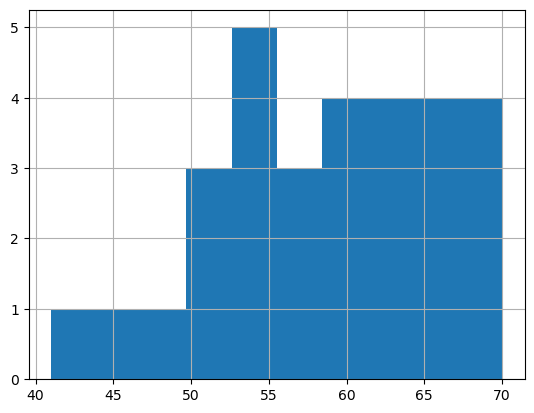

In [144]:
free_viewing_cognitive_empathy = modeler.get_empathy_levels(experiment= "free", type="cognitive")
free_viewing_cognitive_empathy.hist();
free_viewing_cognitive_empathy_median = free_viewing_cognitive_empathy.median()

59.5